# **Taxi Tip Prediction** - A Comparative Study of Decision Tree Regression Using Scikit-Learn and Snap ML

In this project, I consolidate my machine learning modeling skills by using a popular regression model: the **Decision Tree Regressor**.

The dataset used includes real-world information about taxi trips and tips, collected and provided by the **NYC Taxi and Limousine Commission** (TLC) through authorized technology providers under the **Taxicab & Livery Passenger Enhancement Programs** (TPEP/LPEP).

The goal is to train models that can accurately predict the amount of tip paid for taxi rides.

This project offers practice using both the widely-used Scikit-Learn Python interface and the Snap Machine Learning (Snap ML) library. Snap ML is an IBM high-performance machine learning library that provides efficient CPU/GPU implementations of linear and tree-based models, accelerating training and inference while maintaining best-in-class accuracy.

For more information on Snap ML, please visit the IBM [Snap ML](https://research.ibm.com/projects/snap-machine-learning) information page.

## **Introduction**

The dataset used in this project is publicly available from the [NYC Taxi and Limousine Commission (TLC)](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page) website.

For this project, I used the **TLC Yellow Taxi Trip Records** from **June 2019** to build a model that predicts the tip amount given for taxi rides. This problem is approached as a **Regression** task.

To begin, the dataset was downloaded and prepared for analysis and modeling.

In [1]:
# download June 2020 TLC Yellow Taxi Trip records
# !wget -nc https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-06.csv
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/yellow_tripdata_2019-06.csv

--2025-08-29 15:47:32--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/yellow_tripdata_2019-06.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 364904448 (348M) [text/csv]
Saving to: ‘yellow_tripdata_2019-06.csv’

yellow_tripdata_201 100%[===================>] 348.00M  55.6MB/s    in 6.2s    

2025-08-29 15:47:39 (56.2 MB/s) - ‘yellow_tripdata_2019-06.csv’ saved [364904448/364904448]



In [ ]:
# Snap ML is available on PyPI. To install it simply run the pip command below.

!pip install snapml
!pip install scikit-learn
!pip install matplotlib
!pip install pandas
!pip install numpy
%matplotlib inline

The `%matplotlib inline` directive is used to enable inline plotting within Jupyter notebooks for convenient visualization of results.

In [9]:
# Import the libraries we need to use in this lab
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_squared_error
import time
import warnings
import gc, sys
warnings.filterwarnings('ignore')

- `from future import print_function` - ensures consistent behavior of the print function across Python versions.

- `compute_sample_weight` (from sklearn.utils.class_weight) - helps handle imbalanced data by assigning sample weights during model training.

- `gc` (garbage collection) - wllows manual memory cleanup for better resource management with large datasets.

- `sys` - provides access to system-level functions useful for resource management and debugging.

## **Dataset Analysis**

In this section, I load the dataset into a Pandas DataFrame to facilitate efficient data manipulation and exploration.

I will visualize key aspects of the data and examine its basic statistics to better understand its structure and underlying patterns.

**Note:** Pandas DataFrame is a two-dimensional, size-mutable, potentially heterogeneous tabular data structure. For detailed information, see the [Pandas DataFrame documentation.](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)

In [10]:
# read the input data
raw_data = pd.read_csv('yellow_tripdata_2019-06.csv')
print("There are " + str(len(raw_data)) + " observations in the dataset.")
print("\nThere are " + str(len(raw_data.columns)) + " variables in the dataset." + "\n")

# display first rows in the dataset
raw_data.head()

There are 3936004 observations in the dataset.

There are 18 variables in the dataset.



,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-06-01 00:55:13,2019-06-01 00:56:17,1.0,0.0,1.0,N,145.0,145.0,2.0,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
1,1,2019-06-01 00:06:31,2019-06-01 00:06:52,1.0,0.0,1.0,N,262.0,263.0,2.0,2.5,3.0,0.5,0.00,0.0,0.3,6.30,2.5
2,1,2019-06-01 00:17:05,2019-06-01 00:36:38,1.0,4.4,1.0,N,74.0,7.0,2.0,17.5,0.5,0.5,0.00,0.0,0.3,18.80,0.0
3,1,2019-06-01 00:59:02,2019-06-01 00:59:12,0.0,0.8,1.0,N,145.0,145.0,2.0,2.5,1.0,0.5,0.00,0.0,0.3,4.30,0.0
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.7,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5


The dataset contains **3,936,004** observations and **18** variables, capturing detailed taxi trip information.

In [11]:
#Reducing the data size to 100000 records
raw_data=raw_data.head(100000)

To speed up development and reduce memory usage, I limited the dataset to the first 100,000 records using Pandas’ head() method, which retrieves the top rows efficiently. This allows working with a manageable subset while preserving the dataset’s structure for analysis and modeling.

## **Data Preprocessing**

- Each row in the dataset represents a single taxi trip, with 18 variables describing various trip details.

- One of these variables, `tip_amount`, is the target variable I aim to predict using the other features.

The next step is to clean the dataset by handling missing or invalid values and then retrieve basic statistics to understand the distribution and characteristics of the target variable.

There are 65349 observations in the dataset.

There are 17 variables in the dataset.



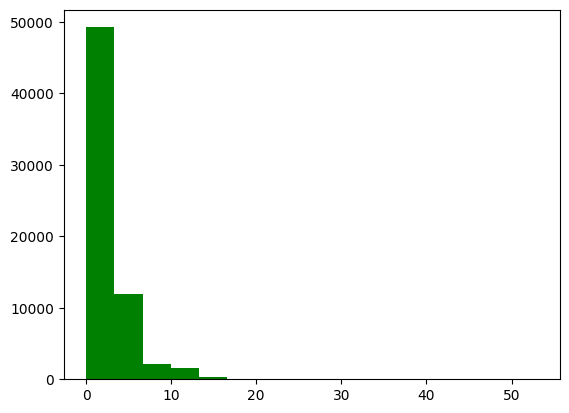


Minimum amount value is  0.01

Maximum amount value is  53.0

90% of the trips have a tip amount less or equal than  5.15


In [12]:
# some trips report 0 tip. it is assumed that these tips were paid in cash.
# for this study we drop all these rows
raw_data = raw_data[raw_data['tip_amount'] > 0]

# we also remove some outliers, namely those where the tip was larger than the fare cost
raw_data = raw_data[(raw_data['tip_amount'] <= raw_data['fare_amount'])]

# we remove trips with very large fare cost
raw_data = raw_data[((raw_data['fare_amount'] >=2) & (raw_data['fare_amount'] < 200))]

# we drop variables that include the target variable in it, namely the total_amount
clean_data = raw_data.drop(['total_amount'], axis=1)

# release memory occupied by raw_data as we do not need it anymore
# we are dealing with a large dataset, thus we need to make sure we do not run out of memory
del raw_data
gc.collect()

# print the number of trips left in the dataset
print("There are " + str(len(clean_data)) + " observations in the dataset.")
print("\nThere are " + str(len(clean_data.columns)) + " variables in the dataset." + "\n")

plt.hist(clean_data.tip_amount.values, 16, histtype='bar', facecolor='g')
plt.show()

print("\nMinimum amount value is ", np.min(clean_data.tip_amount.values))
print("\nMaximum amount value is ", np.max(clean_data.tip_amount.values))
print("\n90% of the trips have a tip amount less or equal than ", np.percentile(clean_data.tip_amount.values, 90))

### **Histogram Evaluation**

- Most taxi trips have a tip amount close to **$0**, with a sharp peak at the **lower end**.

- The frequency of trips drops rapidly as tip amounts increase.

- Tips above **Dollars 10** are uncommon, with very few trips reporting tips greater than **$20**.

- The overall distribution is **right-skewed**, indicating most customers tip modestly, while only a small number give high tips.

This skewed distribution suggests that the regression model should be designed with most predictions expected in the lower tip range.

In [13]:
# display first rows in the dataset
clean_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.70,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,2.5
5,1,2019-06-01 00:28:31,2019-06-01 00:39:23,2.0,1.60,1.0,N,79.0,125.0,1.0,9.5,3.0,0.5,1.00,0.0,0.3,2.5
7,1,2019-06-01 00:54:49,2019-06-01 01:02:57,2.0,1.20,1.0,N,79.0,249.0,1.0,7.5,3.0,0.5,1.00,0.0,0.3,2.5
9,1,2019-06-01 00:29:12,2019-06-01 01:03:13,1.0,8.60,1.0,N,186.0,243.0,1.0,31.5,3.0,0.5,7.05,0.0,0.3,2.5
10,2,2019-06-01 00:01:48,2019-06-01 00:16:06,1.0,1.74,1.0,N,107.0,148.0,1.0,11.0,0.5,0.5,2.96,0.0,0.3,2.5


By looking at the dataset in more detail, we see that it contains information such as pick-up and drop-off dates/times, pick-up and drop-off locations, payment types, driver-reported passenger counts etc. Before actually training a ML model, we will need to preprocess the data. We need to transform the data in a format that will be correctly handled by the models. For instance, we need to encode the categorical features.

The datetime columns will now be converted to extract hour, day, and trip duration features, and the dataset will be limited to **1,000,000** rows for efficient training.

In [14]:
# convert to datetime
clean_data['tpep_dropoff_datetime'] = pd.to_datetime(clean_data['tpep_dropoff_datetime'])
clean_data['tpep_pickup_datetime'] = pd.to_datetime(clean_data['tpep_pickup_datetime'])

# extract pickup and dropoff hour
clean_data['pickup_hour'] = clean_data['tpep_pickup_datetime'].dt.hour
clean_data['dropoff_hour'] = clean_data['tpep_dropoff_datetime'].dt.hour

# extract pickup and dropoff day of week
clean_data['pickup_day'] = clean_data['tpep_pickup_datetime'].dt.weekday
clean_data['dropoff_day'] = clean_data['tpep_dropoff_datetime'].dt.weekday

# compute trip time in minutes
clean_data['trip_time'] = (clean_data['tpep_dropoff_datetime'] - clean_data['tpep_pickup_datetime']).dt.total_seconds() / 60

# reduce dataset size if needed
first_n_rows = 1000000
clean_data = clean_data.head(first_n_rows)

The original datetime columns are now dropped, categorical features are one-hot encoded, and unused data is deleted to free memory.

In [15]:
# drop the pickup and dropoff datetimes
clean_data = clean_data.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

# some features are categorical, we need to encode them
# to encode them we use one-hot encoding from the Pandas package
get_dummy_col = ["VendorID","RatecodeID","store_and_fwd_flag","PULocationID", "DOLocationID","payment_type", "pickup_hour", "dropoff_hour", "pickup_day", "dropoff_day"]
proc_data = pd.get_dummies(clean_data, columns = get_dummy_col)

# release memory occupied by clean_data as we do not need it anymore
# we are dealing with a large dataset, thus we need to make sure we do not run out of memory
del clean_data
gc.collect()

3751

The dataset contains **3,751** features after one-hot encoding and preprocessing.

### **Preparing Features and Labels for Model Training**

- We extract the target variable (`tip_amount`) as labels and remove it from the feature matrix.

- The remaining features are normalized using **L1 norm** to scale values for more effective model training.

- Finally, we print the shapes of the feature and label arrays to verify the data dimensions before training.

In [16]:
# extract the labels from the dataframe
y = proc_data[['tip_amount']].values.astype('float32')

# drop the target variable from the feature matrix
proc_data = proc_data.drop(['tip_amount'], axis=1)

# get the feature matrix used for training
X = proc_data.values

# normalize the feature matrix
X = normalize(X, axis=1, norm='l1', copy=False)

# print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (65349, 460) y.shape= (65349, 1)


The feature matrix X has shape (65,349, 460), indicating **65,349** samples and **460** features, while the label vector y contains **65,349** target values.

### **Dataset Train/Test Split**

Now that the dataset is ready for building the classification models, you need to first divide the pre-processed dataset into a subset to be used for training the model (the train set) and a subset to be used for evaluating the quality of the model (the test set).




In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (45744, 460) Y_train.shape= (45744, 1)
X_test.shape= (19605, 460) Y_test.shape= (19605, 1)


## **Building and Training the Decision Tree Regressor**

Now, we will build a Decision Tree Regressor model using Scikit-Learn to predict the tip amounts.
To ensure consistent results, we set a random seed.
We create the model with a maximum depth of 8 to control its complexity and then train it on the training data.
Finally, we measure and print the time taken to train the model.

In [18]:
# import the Decision Tree Regression Model from scikit-learn
from sklearn.tree import DecisionTreeRegressor

# for reproducible output across multiple function calls, set random_state to a given integer value
sklearn_dt = DecisionTreeRegressor(max_depth=8, random_state=35)

# train a Decision Tree Regressor using scikit-learn
t0 = time.time()
sklearn_dt.fit(X_train, y_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  3.47098


The **Decision Tree Regressor** model trained in approximately **3.47 seconds** using **Scikit-Learn**.

## **Building and Training the Decision Tree Regressor with Snap ML**

Next, we build a Decision Tree Regressor model using Snap ML, which supports multi-threaded CPU and GPU training for faster performance. We configure the model with a maximum depth of 8 and set it to use 4 CPU threads for training. Just like before, we train the model on the training data and measure how long the training takes. If a GPU is available, Snap ML can be easily configured to use it for even faster training.

In [21]:
# import the Decision Tree Regressor Model from Snap ML
from snapml import DecisionTreeRegressor

# in contrast to sklearn's Decision Tree, Snap ML offers multi-threaded CPU/GPU training
# to use the GPU, one needs to set the use_gpu parameter to True
# snapml_dt = DecisionTreeRegressor(max_depth=4, random_state=45, use_gpu=True)

# to set the number of CPU threads used at training time, one needs to set the n_jobs parameter
# for reproducible output across multiple function calls, set random_state to a given integer value
snapml_dt = DecisionTreeRegressor(max_depth=8, random_state=45, n_jobs=4)

# train a Decision Tree Regressor model using Snap ML
t0 = time.time()
snapml_dt.fit(X_train, y_train)
snapml_time = time.time()-t0
print("[Snap ML] Training time (s):  {0:.5f}".format(snapml_time))

[Snap ML] Training time (s):  1.78888


The **Snap ML Decision Tree Regressor** model completed training in approximately **1.79 seconds**, demonstrating `faster` performance compared to **Scikit-Learn**.

## **Evaluating the Scikit-Learn and Snap ML Decision Tree Regressor Models**

We compare the training speed of Snap ML against Scikit-Learn by calculating the speedup factor.
Next, we run predictions on the test dataset using both models.
Finally, we evaluate and print the mean squared error (MSE) for each model to assess their accuracy.

In [23]:
# Snap ML vs Scikit-Learn training speedup
training_speedup = sklearn_time/snapml_time
print('[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))

# run inference using the sklearn model
sklearn_pred = sklearn_dt.predict(X_test)

# evaluate mean squared error on the test dataset
sklearn_mse = mean_squared_error(y_test, sklearn_pred)
print('\n[Scikit-Learn] MSE score : {0:.3f}'.format(sklearn_mse))

# run inference using the Snap ML model
snapml_pred = snapml_dt.predict(X_test)

# evaluate mean squared error on the test dataset
snapml_mse = mean_squared_error(y_test, snapml_pred)
print('\n[Snap ML] MSE score : {0:.3f}'.format(snapml_mse))

[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : 1.94x 

[Scikit-Learn] MSE score : 1.621

[Snap ML] MSE score : 1.694


### **Training Speed and Model Accuracy Comparison**

The Snap ML Decision Tree Regressor trains about **1.94 times faster** than the Scikit-Learn version.

Both models achieve **similar accuracy**, with Scikit-Learn showing a slightly **lower** mean squared error (**1.621**) compared to Snap ML (**1.694**).

## **Conclusion**

Both decision tree models achieve **comparable accuracy** on the test dataset, demonstrating similar **predictive performance**. However, Snap ML offers a significant advantage by **accelerating the training process** compared to Scikit-Learn. This highlights Snap ML’s strength in **speeding up classical machine learning workflows**, such as linear and tree-based models. Additionally, Snap ML integrates seamlessly with Scikit-Learn’s metrics and preprocessing tools, making it a convenient and efficient alternative for model training. For more examples and use cases, please visit [snapml-examples](https://research.ibm.com/projects/snap-machine-learning).

## **Contact**

For any questions or support regarding Snap ML, please contact:

Email: olwinchristian1626@gmail.com